<a href="https://colab.research.google.com/github/peterbmob/DHMVADoE/blob/main/Excercises/LDA_full_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to implement an LDA model from scratch?
You can implement a Linear Discriminant Analysis model from scratch using Python. Let’s start by importing the libraries that are required for the model:

In [1]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Since we will work with the wine dataset, you can obtain it from the UCI machine learning repository. The scikit-learn library in Python provides a wrapper function for downloading it:

In [2]:
wine_info = load_wine()
X = pd.DataFrame(wine_info.data, columns=wine_info.feature_names)
y = pd.Categorical.from_codes(wine_info.target, wine_info.target_names)

The wine dataset comprises of 178 rows of 13 columns each:



In [3]:
X.shape

(178, 13)

The attributes of the wine dataset comprise of various characteristics such as alcohol content of the wine, magnesium content, color intensity, hue and many more:

In [4]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


The wine dataset contains three different kinds of wine:



In [7]:
wine_info.target_names


array(['class_0', 'class_1', 'class_2'], dtype='<U7')

Now we create a DataFrame which will contain both the features and the content of the dataset:

In [5]:
df = X.join(pd.Series(y, name='class'))

We can divide the process of Linear Discriminant Analysis into 5 steps as follows:

1.   Computing the within-class and between-class scatter matrices.
2.   Computing the eigenvectors and their corresponding eigenvalues for the scatter matrices.
3.   Sorting the eigenvalues and selecting the top k.
4. Creating a new matrix that will contain the eigenvectors mapped to the k eigenvalues.
5. Obtaining new features by taking the dot product of the data and the matrix from Step 4.

## Within-class scatter matrix
To calculate the within-class scatter matrix, you can use the following mathematical expression:

$$ S_W= \sum_{i=1}^{c}S_i $$

where,
- c = total number of distinct classes  
- $ S_i = \sum_{x\in D_i}^{n}(x-m_i)(x-m_i)^T $

where
- x = a sample (i.e. a row)
- n = total number of samples within a given class


Now we create a vector with the mean values of each feature:

In [8]:
feature_means1 = pd.DataFrame(columns=wine_info.target_names)
for c, rows in df.groupby('class'):
  feature_means1[c] = rows.mean()
feature_means1

<ipython-input-8-46e196cbdd15>:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  feature_means1[c] = rows.mean()
<ipython-input-8-46e196cbdd15>:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  feature_means1[c] = rows.mean()
<ipython-input-8-46e196cbdd15>:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  

,class_0,class_1,class_2
alcohol,13.744746,12.278732,13.153750
malic_acid,2.010678,1.932676,3.333750
ash,2.455593,2.244789,2.437083
alcalinity_of_ash,17.037288,20.238028,21.416667
magnesium,106.338983,94.549296,99.312500
total_phenols,2.840169,2.258873,1.678750
flavanoids,2.982373,2.080845,0.781458
nonflavanoid_phenols,0.290000,0.363662,0.447500
proanthocyanins,1.899322,1.630282,1.153542
color_intensity,5.528305,3.086620,7.396250


The mean vectors (mi ) are now plugged into the above equations to obtain the within-class scatter matrix:

In [12]:
withinclass_scatter_matrix = np.zeros((13,13))
for c, rows in df.groupby('class'):
  rows = rows.drop(['class'], axis=1)

s = np.zeros((13,13))
for index, row in rows.iterrows():
  x, mc = row.values.reshape(13,1), feature_means1[c].values.reshape(13,1)
  s += (x - mc).dot((x - mc).T)
  withinclass_scatter_matrix += s


# Between-class scatter matrix
We can calculate the between-class scatter matrix using the following mathematical expression:

$$ S_B = \sum_{i=1}^{c}N_i(m_i-m)(m_i-m)^T $$

where
$$ m_i = \frac{1}{n}\sum_{x \ in D_i}^{n} x_k $$
and
$$ m = \frac{1}{n}\sum_{i}^{n}x_i$$


In code, this becomes:

In [14]:
feature_means2 = df.mean()
betweenclass_scatter_matrix = np.zeros((13,13))
for c in feature_means1:
   n = len(df.loc[df['class'] == c].index)
   mc, m = feature_means1[c].values.reshape(13,1), feature_means2.values.reshape(13,1)
   betweenclass_scatter_matrix += n * (mc - m).dot((mc - m).T)

<ipython-input-14-0a45e68d7931>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  feature_means2 = df.mean()


Now we will solve the generalized eigenvalue problem to obtain the linear discriminants for:
$$ S^{-1}_WS_B$$

In [15]:
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(withinclass_scatter_matrix).dot(betweenclass_scatter_matrix))

We will sort the eigenvalues from the highest to the lowest since the eigenvalues with the highest values carry the most information about the distribution of data is done. Next, we will first k eigenvectors. Finally, we will place the eigenvalues in a temporary array to make sure the eigenvalues map to the same eigenvectors after the sorting is done:

In [17]:
eigen_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
eigen_pairs = sorted(eigen_pairs, key=lambda x: x[0], reverse=True)
for pair in eigen_pairs:
  print(pair[0])

9.88454644923297
2.903361061716048
6.296794164165499e-16
6.296794164165499e-16
4.440892098500626e-16
4.2463312738119083e-16
3.59418609296235e-16
3.59418609296235e-16
1.5606603260754855e-16
1.5606603260754855e-16
1.4862208911924154e-16
1.4862208911924154e-16
9.959239102555942e-17


Now we will transform the values into percentage since it is difficult to understand how much of the variance is explained by each component.

In [18]:
sum_of_eigen_values = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(eigen_pairs):
   print('Eigenvector {}: {}'.format(i, (pair[0]/sum_of_eigen_values).real))

Explained Variance
Eigenvector 0: 0.7729604269322258
Eigenvector 1: 0.22703957306777423
Eigenvector 2: 4.9240222911951605e-17
Eigenvector 3: 4.9240222911951605e-17
Eigenvector 4: 3.472727727111203e-17
Eigenvector 5: 3.320583348117114e-17
Eigenvector 6: 2.810613143616346e-17
Eigenvector 7: 2.810613143616346e-17
Eigenvector 8: 1.2204188407988147e-17
Eigenvector 9: 1.2204188407988147e-17
Eigenvector 10: 1.1622080390555779e-17
Eigenvector 11: 1.1622080390555779e-17
Eigenvector 12: 7.78801308504056e-18


First, we will create a new matrix W using the first two eigenvectors:





In [19]:
W_matrix = np.hstack((eigen_pairs[0][1].reshape(13,1), eigen_pairs[1][1].reshape(13,1))).real

Next, we will save the dot product of X and W into a new matrix Y:

$$Y = X*W$$

where, X = n x d matrix with n sample and d dimensions.
            Y = n x k matrix with n sample and k dimensions.

In simple terms, Y is the new matrix or the new feature space.



In [23]:
X_lda = np.array(X.dot(W_matrix))

Our next work is to encode every class a member in order to incorporate the class labels into our plot.

Finally, we plot the data as a function of the two LDA components using different color for each class:

<Axes: xlabel='LDA1', ylabel='LDA2'>

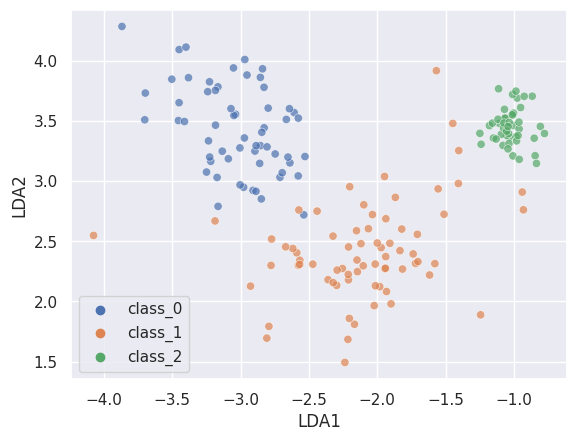

In [28]:
import seaborn as sns

plt.xlabel('LDA1')
plt.ylabel('LDA2')
sns.scatterplot(x=X_lda[:,0],y=X_lda[:,1],hue=y,alpha=0.7,edgecolors='b')

# How to implement LDA using scikit-learn?
For implementing LDA using scikit-learn, let’s work with the same wine dataset. You can also obtain it from the  UCI machine learning repository.

You can use the predefined class LinearDiscriminant Analysis made available to us by the scikit-learn library to implement LDA rather than implementing from scratch every time:

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_model = LinearDiscriminantAnalysis()
X_lda = lda_model.fit(X, y)

To obtain the variance corresponding to each component, you can access the following property:

In [34]:
X_lda.explained_variance_ratio_

array([0.6875, 0.3125])

Again, we will plot the two LDA components just like we did before:


<Axes: xlabel='LDA1', ylabel='LDA2'>

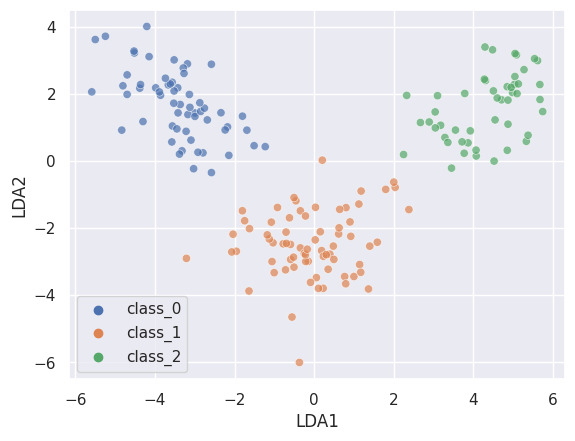

In [35]:
plt.xlabel('LDA1')
plt.ylabel('LDA2')
sns.scatterplot(x=X_lda.transform(X)[:,0],y=X_lda.transform(X)[:,1],hue=y,alpha=0.7,edgecolors='b')

# What would a PCA analysis show?


In [45]:
from sklearn.decomposition import PCA
X_pca = pca(n_components=2).fit(X, y)

Again, to view the values in percentage for a better understanding, we will access the explained_variance_ratio_ property:

In [46]:
X_pca.explained_variance_ratio_

array([0.9981, 0.0017])

Clearly, PCA selected the components which will be able to retain the most information and ignores the ones which maximize the separation between classes.

<Axes: xlabel='PCA1', ylabel='PCA2'>

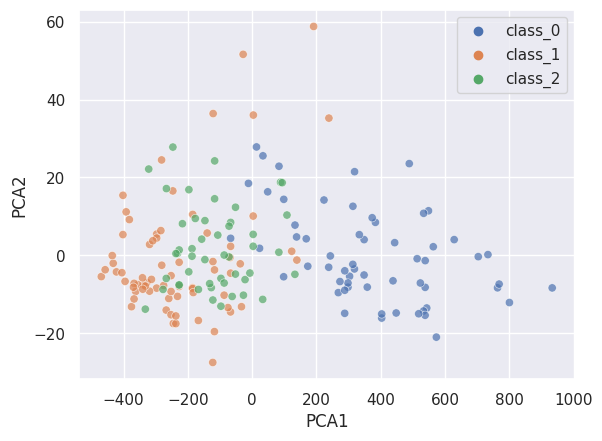

In [47]:
plt.xlabel('PCA1')
plt.ylabel('PCA2')
sns.scatterplot(x=X_pca.transform(X)[:,0],y=X_pca.transform(X)[:,1],hue=y,alpha=0.7,edgecolors='b')

Now to create a classification model using the LDA components as features, we will divide the data into training datasets and testing datasets:

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

The next thing we will do is create a Decision Tree. Then, we will predict the category of each sample test and create a confusion matrix to evaluate the LDA model’s performance:

In [50]:
data = DecisionTreeClassifier()
data.fit(X_train, y_train)
y_pred = data.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[18,  0,  0],
       [ 1, 15,  1],
       [ 0,  0, 10]])

So it is clear that the Decision Tree Classifier has correctly classified everything in the test dataset.

We can also use the metrics function in the sklearn library to evaluate the performance of the classifier model:

In [52]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9555555555555556


We have a 95 prediction accuracy on our test set.